House Price competition is a very good way to introduce feature engineering and regression models. I'm gonna explore the data and make something with them and also imput missing values. Feature engineering is an important part of machine learning process so I want to spend more time for this part. I'm gonna try I few models and tell you which work the best with train dataset from this competition. Please consider upvoting if this is useful to you :)

**Import the Libraries**

In [233]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import math 
np.random.seed(2019)
from scipy.stats import skew
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor

import statsmodels

#!pip install ml_metrics
from ml_metrics import rmsle

import matplotlib.pyplot as plt
%matplotlib inline
print("done")

done


**Import Data**

I'm adding here 'train' variable in order to check in the easiest way which observations are from train and test dataset because I'm gonna join train and test datasets.

In [234]:
def read_and_concat_dataset(training_path, test_path):
    train = pd.read_csv(training_path)
    train['train'] = 1
    test = pd.read_csv(test_path)
    test['train'] = 0
    data = train.append(test, ignore_index=True)
    return train, test, data

train, test, data = read_and_concat_dataset('../input/train.csv', '../input/test.csv')
data = data.set_index('Id')

In [235]:
data.columns[data.isnull().sum()>0]

Index(['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'Electrical', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Functional', 'GarageArea', 'GarageCars',
       'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt',
       'KitchenQual', 'LotFrontage', 'MSZoning', 'MasVnrArea', 'MasVnrType',
       'MiscFeature', 'PoolQC', 'SalePrice', 'SaleType', 'TotalBsmtSF',
       'Utilities'],
      dtype='object')

There are a few variables with NaN value but in these cases 'NaN' means something else than missing value. For example 'NaN' in 'GarageCond' means that this house hasn't a garage. I'm gonna change 'NaN' values to 'None' string. 

**Fixing variables**

In [236]:
def filling_missing_values(data,variable, new_value):
    data[variable] = data[variable].fillna(new_value)

In [237]:
filling_missing_values(data,'GarageCond','None')
filling_missing_values(data,'GarageQual','None')
filling_missing_values(data,'FireplaceQu','None')
filling_missing_values(data,'BsmtCond','None')
filling_missing_values(data,'BsmtQual','None')
filling_missing_values(data,'PoolQC','None')
filling_missing_values(data,'MiscFeature','None')

MSSubClass is not a numerical variables, so let's transform it to caterogical variable.

In [238]:
data['MSSubClass'][data['MSSubClass'] == 20] = '1-STORY 1946 & NEWER ALL STYLES'
data['MSSubClass'][data['MSSubClass'] == 30] = '1-STORY 1945 & OLDER'
data['MSSubClass'][data['MSSubClass'] == 40] = '1-STORY W/FINISHED ATTIC ALL AGES'
data['MSSubClass'][data['MSSubClass'] == 45] = '1-1/2 STORY - UNFINISHED ALL AGES'
data['MSSubClass'][data['MSSubClass'] == 50] = '1-1/2 STORY FINISHED ALL AGES'
data['MSSubClass'][data['MSSubClass'] == 60] = '2-STORY 1946 & NEWER'
data['MSSubClass'][data['MSSubClass'] == 70] = '2-STORY 1945 & OLDER'
data['MSSubClass'][data['MSSubClass'] == 75] = '2-1/2 STORY ALL AGES'
data['MSSubClass'][data['MSSubClass'] == 80] = 'SPLIT OR MULTI-LEVEL'
data['MSSubClass'][data['MSSubClass'] == 85] = 'SPLIT FOYER'
data['MSSubClass'][data['MSSubClass'] == 90] = 'DUPLEX - ALL STYLES AND AGES'
data['MSSubClass'][data['MSSubClass'] == 120] = '1-STORY PUD (Planned Unit Development) - 1946 & NEWER'
data['MSSubClass'][data['MSSubClass'] == 150] = '1-1/2 STORY PUD - ALL AGES'
data['MSSubClass'][data['MSSubClass'] == 160] = '2-STORY PUD - 1946 & NEWER'
data['MSSubClass'][data['MSSubClass'] == 180] = 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER'
data['MSSubClass'][data['MSSubClass'] == 190] = '2 FAMILY CONVERSION - ALL STYLES AND AGES'

A few categorical variables are ordinal variables, so let's fix them

In [239]:
def fixing_ordinal_variables(data, variable):
    data[variable][data[variable] == 'Ex'] = 5
    data[variable][data[variable] == 'Gd'] = 4
    data[variable][data[variable] == 'TA'] = 3
    data[variable][data[variable] == 'Fa'] = 2
    data[variable][data[variable] == 'Po'] = 1
    data[variable][data[variable] == 'None'] = 0

In [240]:
fixing_ordinal_variables(data,'ExterQual')
fixing_ordinal_variables(data,'ExterCond')
fixing_ordinal_variables(data,'BsmtCond')
fixing_ordinal_variables(data,'BsmtQual')
fixing_ordinal_variables(data,'HeatingQC')
fixing_ordinal_variables(data,'KitchenQual')
fixing_ordinal_variables(data,'FireplaceQu')
fixing_ordinal_variables(data,'GarageQual')
fixing_ordinal_variables(data,'GarageCond')
fixing_ordinal_variables(data,'PoolQC')

..and one more but in different way.

In [241]:
data['PavedDrive'][data['PavedDrive'] == 'Y'] = 3
data['PavedDrive'][data['PavedDrive'] == 'P'] = 2
data['PavedDrive'][data['PavedDrive'] == 'N'] = 1

**Missing values**

First of all I'm gonna look how many variables have less than 50 missing values and fix it. Then I'll look how about variables with more than 50 missing values.

In [242]:
colu = data.columns[(data.isnull().sum()<50) & (data.isnull().sum()>0)]
for i in colu:
    print(data[colu].isnull().sum())

BsmtFinSF1       1
BsmtFinSF2       1
BsmtFullBath     2
BsmtHalfBath     2
BsmtUnfSF        1
Electrical       1
Exterior1st      1
Exterior2nd      1
Functional       2
GarageArea       1
GarageCars       1
KitchenQual      1
MSZoning         4
MasVnrArea      23
MasVnrType      24
SaleType         1
TotalBsmtSF      1
Utilities        2
dtype: int64
BsmtFinSF1       1
BsmtFinSF2       1
BsmtFullBath     2
BsmtHalfBath     2
BsmtUnfSF        1
Electrical       1
Exterior1st      1
Exterior2nd      1
Functional       2
GarageArea       1
GarageCars       1
KitchenQual      1
MSZoning         4
MasVnrArea      23
MasVnrType      24
SaleType         1
TotalBsmtSF      1
Utilities        2
dtype: int64
BsmtFinSF1       1
BsmtFinSF2       1
BsmtFullBath     2
BsmtHalfBath     2
BsmtUnfSF        1
Electrical       1
Exterior1st      1
Exterior2nd      1
Functional       2
GarageArea       1
GarageCars       1
KitchenQual      1
MSZoning         4
MasVnrArea      23
MasVnrType      24
SaleT

In [243]:
colu = data.columns[data.isnull().sum()>=50]
for i in colu:
    print(data[colu].isnull().sum())

Alley           2721
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Fence           2348
GarageFinish     159
GarageType       157
GarageYrBlt      159
LotFrontage      486
SalePrice       1459
dtype: int64
Alley           2721
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Fence           2348
GarageFinish     159
GarageType       157
GarageYrBlt      159
LotFrontage      486
SalePrice       1459
dtype: int64
Alley           2721
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Fence           2348
GarageFinish     159
GarageType       157
GarageYrBlt      159
LotFrontage      486
SalePrice       1459
dtype: int64
Alley           2721
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Fence           2348
GarageFinish     159
GarageType       157
GarageYrBlt      159
LotFrontage      486
SalePrice       1459
dtype: int64
Alley           2721
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Fence           2348
Gar

I'm putting 0 in GarageArea, GarageFinish, GarageType, GarageYrBlt and GarageCars where houses don't have garage. 

In [244]:
filling_missing_values(data, 'GarageArea',0)
filling_missing_values(data, 'GarageCars',0)

In [245]:
data['GarageFinish'][(data.GarageFinish.isnull()==True) & (data.GarageCond==0)] =0
data['GarageType'][(data.GarageType.isnull()==True) & (data.GarageCond==0)] =0
data['GarageYrBlt'][(data.GarageYrBlt.isnull()==True) & (data.GarageCond==0)] =0

I'm gonna put 0 in MiscVal for house which don't have any MiscFeature and 'None' value for house with 0 in MiscValue and some value in MiscFeature.

In [246]:
print(data[['MiscFeature','MiscVal']][(data.MiscFeature=='None') & (data.MiscVal>0)])
data.MiscVal.loc[2550] = 0

print(data[['MiscFeature','MiscVal']][(data.MiscVal==0) & (data.MiscFeature!='None')])
c=data[['MiscFeature','MiscVal']][(data.MiscVal==0) & (data.MiscFeature!='None')].index
data.MiscFeature.loc[c] = 'None'

     MiscFeature  MiscVal
Id                       
2550        None    17000
     MiscFeature  MiscVal
Id                       
874         Othr        0
1201        Shed        0
2432        Shed        0


Now I'm gonna write two functions to help me in imputing missing values in variables. I'm using here Random Forest Regressor and Classifier. 

In [247]:
def inputing(variab):
    y = data[variab]
    data2 = data.drop([variab],axis=1)
    col = data2.columns[data2.isnull().sum()==0]
    data2 = data2[col]
    data2 = pd.get_dummies(data2)
    c_train = y[y.notnull()==True].index
    y_train = y[c_train]
    columny = data2.columns
    X_train = data2[columny].loc[c_train]
    c_test = y[y.notnull()!=True].index
    y_test = y[c_test]
    X_test = data2[columny].loc[c_test]
    #Model
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #Filling missing data
    y_pred = pd.Series(y_pred, index=c_test)
    data[variab].loc[c_test] = y_pred.loc[c_test]
    
def inputing_numerical(variab):
    y = data[variab]
    data2 = data.drop([variab],axis=1)
    col = data2.columns[data2.isnull().sum()==0]
    data2 = data2[col]
    data2 = pd.get_dummies(data2)
    c_train = y[y.notnull()==True].index
    y_train = y[c_train]
    columny = data2.columns
    X_train = data2[columny].loc[c_train]
    c_test = y[y.notnull()!=True].index
    y_test = y[c_test]
    X_test = data2[columny].loc[c_test]
    #Model
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #Filling missing data
    y_pred = pd.Series(y_pred, index=c_test)
    data[variab].loc[c_test] = y_pred.loc[c_test]

Let's imput missing values using two functions which I wrote. In KitchenQual, BsmtFullBath and BsmtHalfBath cases I'm gonna use Regressor model and convert them to integer.

In [248]:
inputing(variab='Electrical')
inputing(variab='Exterior2nd')
inputing(variab='Exterior1st')
inputing(variab='MasVnrType')
inputing(variab='Functional')
inputing(variab='MSZoning')
inputing(variab='SaleType')
inputing(variab='Alley')
inputing(variab='BsmtExposure')
inputing(variab='BsmtFinType1')
inputing(variab='BsmtFinType2')
inputing(variab='Fence')

inputing_numerical(variab='KitchenQual')
data['KitchenQual'] = data.KitchenQual.astype(int)
inputing_numerical(variab='BsmtFullBath')
data['BsmtFullBath'] = data.BsmtFullBath.astype(int)
inputing_numerical(variab='BsmtHalfBath')
data['BsmtHalfBath'] = data.BsmtHalfBath.astype(int)

inputing_numerical(variab='TotalBsmtSF')
inputing_numerical(variab='BsmtFinSF1')
inputing_numerical(variab='BsmtFinSF2')
inputing_numerical(variab='MasVnrArea')
inputingnum(variab='BsmtUnfSF')
inputing_numerical(variab='LotFrontage')

In [249]:
print(data['Utilities'].value_counts())
data  = data.drop(['Utilities'],axis=1)

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64


In [250]:
data.columns[data.isnull().sum()>0]

Index(['SalePrice'], dtype='object')

It's everything about imputing missing values.

Let's understand a data set variable after variable, check basic statistics and drop a few outliers. I'll also drop variables with little differentiation. 

In [251]:
data.describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,PoolArea,SalePrice,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,train
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,...,2919.000000,1460.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,1159.581706,336.483727,2.602261,2.860226,441.272011,49.565262,0.429599,0.061322,560.579993,23.098321,...,2.251799,180921.195890,16.062350,6.451524,1051.417266,93.709832,1971.312778,1984.264474,2007.792737,0.500171
std,392.362079,428.701456,25.188169,0.822693,455.606014,169.179104,0.524676,0.245608,439.590889,64.244246,...,35.663946,79442.502883,56.184365,1.569379,441.120498,126.526589,30.291442,20.894344,1.314964,0.500086
min,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,34900.000000,0.000000,2.000000,0.000000,0.000000,1872.000000,1950.000000,2006.000000,0.000000
25%,876.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,220.000000,0.000000,...,0.000000,129975.000000,0.000000,5.000000,793.000000,0.000000,1953.500000,1965.000000,2007.000000,0.000000
50%,1082.000000,0.000000,0.000000,3.000000,368.000000,0.000000,0.000000,0.000000,467.000000,0.000000,...,0.000000,163000.000000,0.000000,6.000000,989.000000,0.000000,1973.000000,1993.000000,2008.000000,1.000000
75%,1387.500000,704.000000,0.000000,3.000000,733.000000,0.000000,1.000000,0.000000,805.000000,0.000000,...,0.000000,214000.000000,0.000000,7.000000,1302.000000,168.000000,2001.000000,2004.000000,2009.000000,1.000000
max,5095.000000,2065.000000,508.000000,8.000000,5644.000000,1526.000000,3.000000,2.000000,2336.000000,1012.000000,...,800.000000,755000.000000,576.000000,15.000000,6110.000000,1424.000000,2010.000000,2010.000000,2010.000000,1.000000


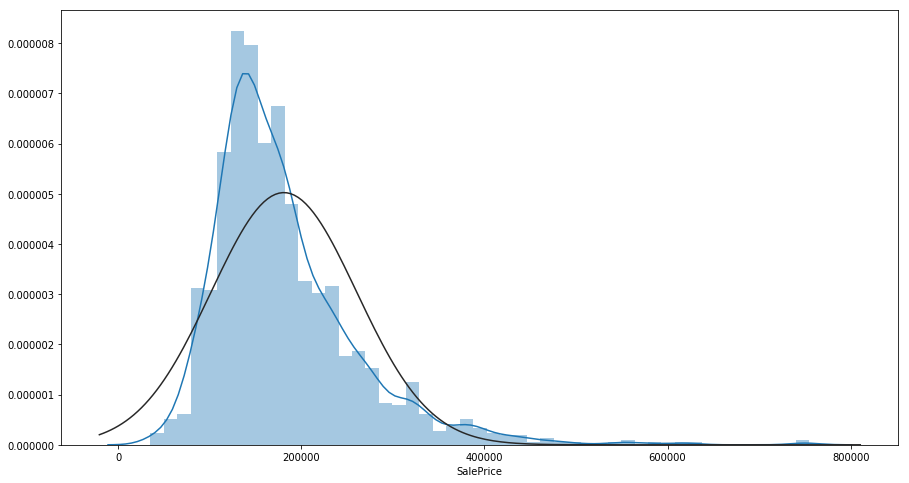

In [252]:
from scipy.stats import norm
plt.figure(figsize=(15,8))
sns.distplot(data['SalePrice'][data.SalePrice.isnull()==False], fit= norm,kde=True)
plt.show()

**Dropping outliers**

On the scatter charts, I checked which observations could be considered outliers and I decided to delete them.
I must be very careful because I don't want to remove observations from the test set.

For example, let's look at scatter plot of SalePrice and Lot Frontage.

AxesSubplot(0.125,0.125;0.775x0.755)


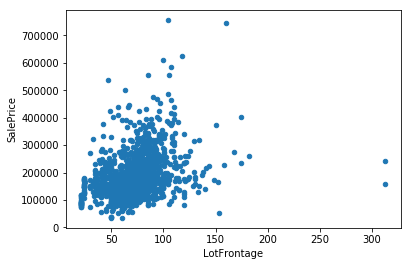

In [253]:
print(data.plot.scatter(x='LotFrontage',y='SalePrice'))

In [254]:
def dropping_outliers(data, condition):
    #put condition with with reference to the data table, use brackets and (& |) operators, remember about you can drop observation only from train dataset
    condition_to_drop = data[condition].index
    data = data.drop(condition_to_drop)

In [255]:
dropping_outliers(data, (data.SalePrice<100000) & (data.train==1) & (data.LotFrontage>150))
dropping_outliers(data, (data.LotFrontage>200) & (data.train==1))
dropping_outliers(data, (data.SalePrice>700000) & (data.train==1))
dropping_outliers(data, (data.SalePrice>700000) & (data.train==1))
dropping_outliers(data, (data.LotArea>60000) & (data.train==1))
dropping_outliers(data, (data.MasVnrArea>1450) & (data.train==1))
dropping_outliers(data, (data.BedroomAbvGr==8) & (data.train==1))
dropping_outliers(data, (data.KitchenAbvGr==3) & (data.train==1))
dropping_outliers(data, (data['3SsnPorch']>400) & (data.train==1))
dropping_outliers(data, (data.LotArea>100000) & (data.train==1))
dropping_outliers(data, (data.MasVnrArea>1300) & (data.train==1))
dropping_outliers(data, (data.BsmtFinSF1>2000) & (data.train==1) & (data.SalePrice<300000))
dropping_outliers(data, (data.BsmtFinSF2>200) & (data.SalePrice>350000)  & (data.train==1))
dropping_outliers(data, (data.BedroomAbvGr==8) & (data.train==1))
dropping_outliers(data, (data.KitchenAbvGr==3) & (data.train==1))
dropping_outliers(data, (data.TotRmsAbvGrd==2) & (data.train==1))

CentalAir variable needs transformation to binary variable.

In [256]:
print(data['CentralAir'].value_counts())
data['CentralAir'] = pd.Series(np.where(data['CentralAir'].values == 'Y', 1, 0),
          data.index)

Y    2723
N     196
Name: CentralAir, dtype: int64


**Feature engineering**

* 2ndFloor - if the house has a second floor
* Floors - total area of the first and second floor
* TotBath - how many bathrooms house has
* Porch - total area of the porch
* TotalSF - total area of the house
* Pool - if the house has a swimming pool
* Bsmt - if the house has a basement
* Garage - if the house has a garage
* Fireplace - if the house has a fireplace
* Remod - if the house was renovated
* NewHouse - if the house is new
* Age - ages of house


In [257]:
data['2ndFloor'] = pd.Series(np.where(data['2ndFlrSF'].values == 0, 0, 1),data.index)
data['Floors'] = data['1stFlrSF'] + data['2ndFlrSF']
data['TotBath'] = data['FullBath'] + (0.5 * data['HalfBath']) + data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath'])
data['Porch'] = data['OpenPorchSF'] + data['3SsnPorch'] + data['EnclosedPorch'] + data['ScreenPorch']
data['TotalSF'] = data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['Floors'] 
data['Pool'] = pd.Series(np.where(data['PoolArea'].values == 0, 0, 1),data.index)
data['Bsmt'] = pd.Series(np.where(data['TotalBsmtSF'].values == 0, 0, 1),data.index)
data['Garage'] = pd.Series(np.where(data['GarageArea'].values == 0, 0, 1),data.index)
data['Fireplace'] = pd.Series(np.where(data['Fireplaces'].values == 0, 0, 1),data.index)
data['Remod'] = pd.Series(np.where(data['YearBuilt'].values == data['YearRemodAdd'].values, 0, 1),data.index)
data['NewHouse'] = pd.Series(np.where(data['YearBuilt'].values == data['YrSold'].values, 1, 0),data.index)
data['Age'] = data['YrSold'] - data['YearRemodAdd']

I'm gonna drop more observations.

In [258]:
dropping_outliers(data, (data.Floors>4000) & (data.train==1))
dropping_outliers(data, (data.SalePrice>500000) & (data['TotalSF']<3500) & (data.train==1))

**Droping a few variables**

In [259]:
data = data.drop(['PoolQC','GrLivArea','Street','GarageYrBlt','PoolArea','MiscFeature','1stFlrSF','2ndFlrSF'],axis=1)

**Preparing to modeling:**
- dummies variables
- two data frames with independent variables for train and test set
- vector y with Sale Price variable for train set

**Modeling:**

- XGB Regressor
- Decision Tree Regressor
- Random Forest Regressor
- LASSO Regression


For each model I tuned the parameters using loops and each model contains SalePrice variable tranformed to logarithm.

In [260]:
Results = pd.DataFrame({'Model': [],'Accuracy Score': []})

In [261]:
data = pd.get_dummies(data)

**XGBoost Regressor**

In [271]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(data[data.SalePrice.isnull()==False].drop('SalePrice',axis=1),data.SalePrice[data.SalePrice.isnull()==False],test_size=0.30, random_state=2019)
trainY = np.log(trainY)

model = XGBRegressor(learning_rate=0.001,n_estimators=4600,
                                max_depth=7, min_child_weight=0,
                                gamma=0, subsample=0.7,
                                colsample_bytree=0.7,
                                scale_pos_weight=1, seed=27,
                                reg_alpha=0.00006)
model.fit(trainX,trainY)
y_pred = model.predict(testX)
y_pred = np.exp(y_pred)

print(rmsle(testY, y_pred))

res = pd.DataFrame({"Model":['XGBoost'],
                    "Accuracy Score": [rmsle(testY, y_pred)]})
Results = Results.append(res)

[14:02:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.17954337097764494


**Decision Tree Regressor**

In [263]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(data[data.SalePrice.isnull()==False].drop('SalePrice',axis=1),data.SalePrice[data.SalePrice.isnull()==False],test_size=0.30, random_state=2019)
trainY = np.log(trainY)

model = DecisionTreeRegressor(max_depth=6)
model.fit(trainX,trainY)
y_pred = model.predict(testX)
y_pred = np.exp(y_pred)

print(rmsle(testY, y_pred))

res = pd.DataFrame({"Model":['Decision Tree'],
                    "Accuracy Score": [rmsle(testY, y_pred)]})
Results = Results.append(res)

0.2051504797549568


In [264]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(data[data.SalePrice.isnull()==False].drop('SalePrice',axis=1),data.SalePrice[data.SalePrice.isnull()==False],test_size=0.30, random_state=2019)
trainY = np.log(trainY)

model = RandomForestRegressor(n_estimators=1500,
                                max_depth=6)
model.fit(trainX,trainY)
y_pred = model.predict(testX)
y_pred = np.exp(y_pred)
print(rmsle(testY, y_pred))

res = pd.DataFrame({"Model":['Random Forest'],
                    "Accuracy Score": [rmsle(testY, y_pred)]})
Results = Results.append(res)

0.1601380740342682


**LASSO Regression**

In [265]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(data[data.SalePrice.isnull()==False].drop('SalePrice',axis=1),data.SalePrice[data.SalePrice.isnull()==False],test_size=0.30, random_state=2019)
trainY = np.log(trainY)

model = Lasso(alpha=0.0005)

model.fit(trainX,trainY)
y_pred = model.predict(testX)
y_pred = np.exp(y_pred)
print(rmsle(testY, y_pred))

res = pd.DataFrame({"Model":['LASSO'],
                    "Accuracy Score": [rmsle(testY, y_pred)]})
Results = Results.append(res)

0.12222884351321135


**Stepwise Regression**

In [266]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(data[data.SalePrice.isnull()==False].drop('SalePrice',axis=1),data.SalePrice[data.SalePrice.isnull()==False],test_size=0.30, random_state=2019)
trainY = np.log(trainY)

X2 = sm.add_constant(trainX)
o=0
for i in X2.columns:
    o+=1
    print(o)
    model = sm.OLS(trainY, X2.astype(float))
    model = model.fit()
    p_values = pd.DataFrame(model.pvalues)
    p_values = p_values.sort_values(by=0, ascending=False)
    if float(p_values.loc[p_values.index[0]])>=0.05:
        X2=X2.drop(p_values.index[0],axis=1)
    else:
        break

kolumny = X2.columns
testX = sm.add_constant(testX)
testX = testX[kolumny]

y_pred = model.predict(testX)
y_pred = np.exp(y_pred)


res = pd.DataFrame({"Model":['Stepwise Regression'],
                    "Accuracy Score": [rmsle(testY, y_pred)]})
Results = Results.append(res)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143


**Ridge Regression**

In [267]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(data[data.SalePrice.isnull()==False].drop('SalePrice',axis=1),data.SalePrice[data.SalePrice.isnull()==False],test_size=0.30, random_state=2019)
trainY = np.log(trainY)

model = Ridge(alpha=0.0005)

model.fit(trainX,trainY)
y_pred = model.predict(testX)
y_pred = np.exp(y_pred)
print(rmsle(testY, y_pred))

res = pd.DataFrame({"Model":['Ridge'],
                    "Accuracy Score": [rmsle(testY, y_pred)]})
Results = Results.append(res)

0.14450316650654157


**Linear Regression**

When you change alpha to 0 value in LASSO, you have simple Linear Regression model.

In [273]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(data[data.SalePrice.isnull()==False].drop('SalePrice',axis=1),data.SalePrice[data.SalePrice.isnull()==False],test_size=0.30, random_state=2019)
trainY = np.log(trainY)

model = Lasso(alpha=0)

model.fit(trainX,trainY)
y_pred = model.predict(testX)
y_pred = np.exp(y_pred)
print(rmsle(testY, y_pred))

res = pd.DataFrame({"Model":['Linear Regression'],
                    "Accuracy Score": [rmsle(testY, y_pred)]})
Results = Results.append(res)

Id
1049    115000.0
538     111250.0
1416    175900.0
629     135000.0
90      123600.0
          ...   
609     359100.0
415     228000.0
1196    176000.0
882     187500.0
843     174900.0
Name: SalePrice, Length: 438, dtype: float64

In [269]:
Results

,Model,Accuracy Score
0,XGBoost,0.179543
0,Decision Tree,0.205150
0,Random Forest,0.160138
0,LASSO,0.122229
0,Stepwise Regression,0.141364
0,Ridge,0.144503
0,Linear Regression,0.139368


LASSO Regression model gives the best results. This model helps me to get 0.12903 (RMSLE) on competition test dataset and it gives me place in 21% best results on Leaderboard.

In [270]:
trainX = data[data.SalePrice.isnull()==False].drop(['SalePrice','train'],axis=1)
trainY = data.SalePrice[data.SalePrice.isnull()==False]
testX = data[data.SalePrice.isnull()==True].drop(['SalePrice','train'],axis=1)
trainY = np.log(trainY)
model = Lasso(alpha=0.0005)
model.fit(trainX, trainY)
test = data[data.train==0]
test['SalePrice'] = model.predict(testX)
test['SalePrice'] = np.exp(test['SalePrice'] )
test = test.reset_index()
test[['Id','SalePrice']].to_csv("submissionLASSO.csv",index=False)
print("done1")

done1
